# COMISIÓN NACIONAL DE ACTIVIDADES ESPACIALES
## UNIDAD DE FORMACIÓN SUPERIOR
## Maestría en Instrumentos Satelitales
### Tema 9: Criterio de Nyquist. Familia de pulsos de coseno realzado. Filtro apareado.  Analizar mediante diagrama ojo, constelación y curva de BER. Sólo con hardware Pluto.

### Librerías

In [1]:
#! pip install scikit-dsp-comm
#! pip install scikit-commpy
import numpy as np
import matplotlib.pyplot as plt
from sk_dsp_comm import digitalcom as dc
import commpy # Para el filtro RRC
import adi    # Para la Pluto

## Generación de la señal a transmitir (QPSK)

### Parámetros de configuración

In [2]:
fs = 1000000   # [Hz] Frecuencia de muestreo
print('Frecuencia de muestreo:',fs,'Hz')

duracion = 0.002 # [s] Duración de la señal
N_bits = np.int(fs*duracion) # Número total de bits
print('Largo de la señal:',N_bits,'bits')

sps = 8 # Samples per symbol
print('Muestras por símbolo:',sps,'muestras')

Frecuencia de muestreo: 1000000 Hz
Largo de la señal: 2000 bits
Muestras por símbolo: 8 muestras


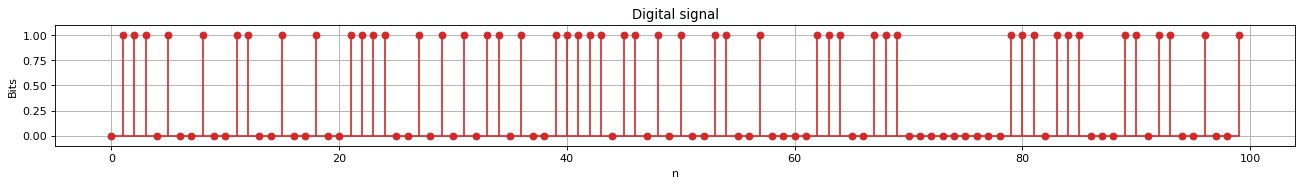

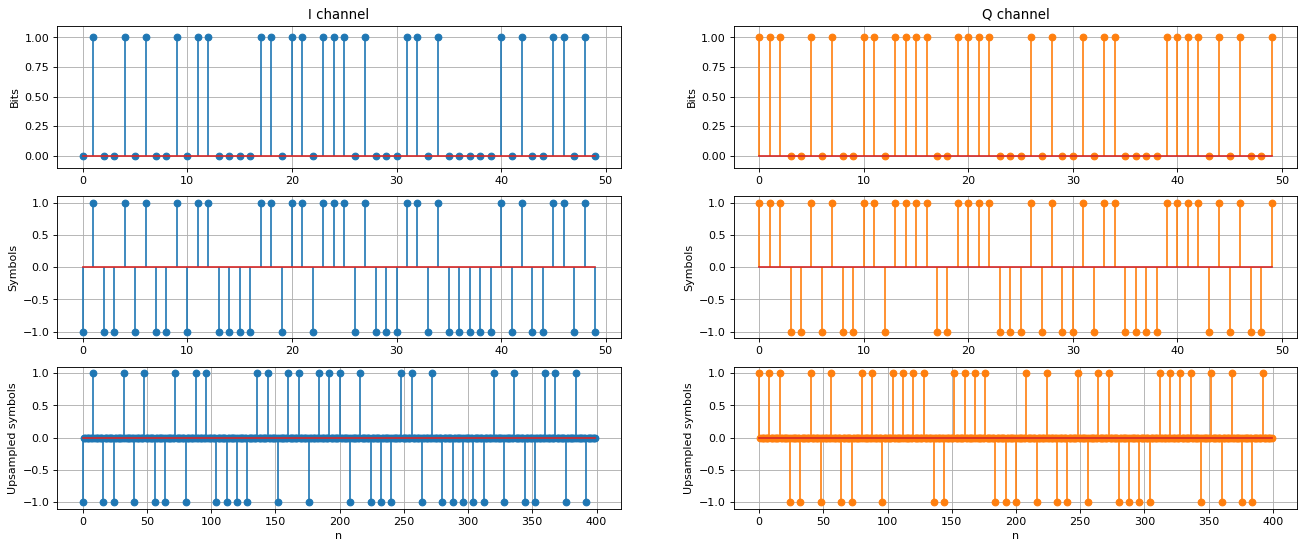

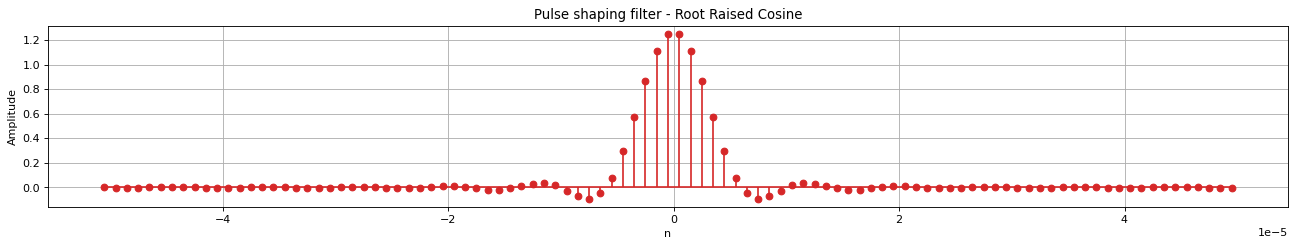

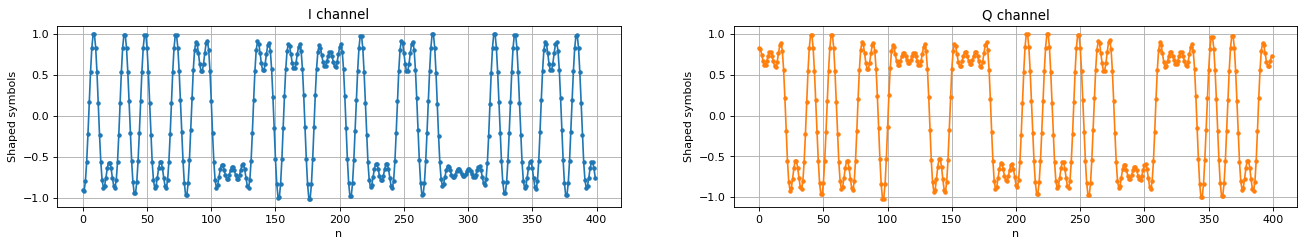

In [3]:
##########################################################################################
# Datos binarios a transmitir
##########################################################################################
n = int(N_bits/20)
n_bits = np.random.randint(2, size=n)
bits = np.tile(n_bits,20)
plt.figure(figsize=(20,2), dpi= 80, facecolor='w', edgecolor='k')
plt.stem(bits[0:100],use_line_collection=True,linefmt='C3-',markerfmt='C3o')
plt.title('Digital signal')
plt.ylabel('Bits')
plt.ylim([-0.1, 1.1])
plt.xlabel('n')
plt.grid()
plt.show()


##########################################################################################
# Canal I
##########################################################################################
i_bits = bits[0::2] # Tomo uno de cada 2 bits comenzado por el bit en la posición 0
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(3,2,1)
plt.stem(i_bits[0:50],use_line_collection=True)
plt.title('I channel')
plt.ylabel('Bits')
plt.ylim([-0.1, 1.1])
plt.grid()

i_symbols = 2*i_bits-1 # Convierto los valores binarios 0 y 1 en -1 y 1
plt.subplot(3,2,3)
plt.stem(i_symbols[0:50])
plt.ylabel('Symbols')
plt.ylim([-1.1, 1.1])
plt.grid()

i_upsampled = np.array([])
for symbol in i_symbols:
    pulse = np.zeros(sps)
    pulse[0] = symbol 
    i_upsampled = np.concatenate((i_upsampled, pulse)) # add the 8 samples to the signal
plt.subplot(3,2,5)
plt.stem(i_upsampled[0:400])
plt.ylabel('Upsampled symbols')
plt.xlabel('n')
plt.grid()


##########################################################################################
# Canal Q
##########################################################################################
q_bits = bits[1::2] # Tomo uno de cada 2 bits comenzado por el bit en la posición 1
plt.subplot(3,2,2)
plt.stem(q_bits[0:50],linefmt='C1-',markerfmt='C1o')
plt.title('Q channel')
plt.ylabel('Bits')
plt.ylim([-0.1, 1.1])
plt.grid()

q_symbols = 2*q_bits-1  # Convierto los valores binarios 0 y 1 en -1 y 1
plt.subplot(3,2,4)
plt.stem(q_symbols[0:50],linefmt='C1-',markerfmt='C1o')
plt.ylabel('Symbols')
plt.ylim([-1.1, 1.1])
plt.grid()

q_upsampled = np.array([])
for symbol in q_symbols:
    pulse = np.zeros(sps)
    pulse[0] = symbol 
    q_upsampled = np.concatenate((q_upsampled, pulse)) # add the 8 samples to the signal
plt.subplot(3,2,6)
plt.stem(q_upsampled[0:400],linefmt='C1-',markerfmt='C1o')
plt.ylabel('Upsampled symbols')
plt.xlabel('n')
plt.grid()
plt.show()


##########################################################################################
# Filtro conformador de pulso raíz de coseno realzado (RRC)
##########################################################################################
num_taps = 101
beta = 0.99
Ts = sps/fs

t_rrc,h_rrc = commpy.filters.rrcosfilter(num_taps,beta,Ts,fs)

plt.figure(figsize=(20,3), dpi= 80, facecolor='w', edgecolor='k')
plt.stem(t_rrc,h_rrc,linefmt='C3-',markerfmt='C3o')
plt.title('Pulse shaping filter - Root Raised Cosine')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid(True)
plt.show()


##########################################################################################
# Filtrado de la señal (canales I y Q)
##########################################################################################
i_shaped = np.convolve(i_upsampled, h_rrc)
tau_g = int(num_taps/2)
i_shaped = i_shaped[tau_g:-tau_g]/np.max(i_shaped) # Elimino los transitorios y normalizo

plt.figure(figsize=(20,3), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(i_shaped[0:400], '.-')
plt.title('I channel')
plt.ylabel('Shaped symbols')
plt.xlabel('n')
plt.grid()

# Filter our signal, in order to apply the pulse shaping
q_shaped = np.convolve(q_upsampled, h_rrc)
q_shaped = q_shaped[tau_g:-tau_g]/np.max(q_shaped) # Elimino los transitorios y normalizo

plt.subplot(1,2,2)
plt.plot(q_shaped[0:400], 'C1.-')
plt.title('Q channel')
plt.ylabel('Shaped symbols')
plt.xlabel('n')
plt.grid()
plt.show()

# Transmisión y recepción de la señal con ADALM-PLUTO

![AD9361](AD9361_BlockDiagram.png)

![Loopback](Loopback_digital.png)

# Loopback digital

### Parámetros de configuración

In [4]:
# Libero la Pluto
del(sdr)

NameError: name 'sdr' is not defined

In [75]:
# Conformación de la señal a transmitir:
st = (i_shaped + 1j*q_shaped)*2**14

sdr = adi.Pluto()

# Parámetros de transmisión:
sdr.tx_destroy_buffer()
sdr.tx_lo = 1000000000 # [Hz]
sdr.tx_cyclic_buffer = True
sdr.tx_hardwaregain_chan0 = -10

# Parámetros de recepción
sdr.rx_destroy_buffer()
sdr.rx_lo = 1000000000 # [Hz]
sdr.rx_rf_bandwidth = 10000
sdr.rx_cyclic_buffer = True
sdr.rx_buffer_size = len(st)
print('Tamaño del buffer:',sdr.rx_buffer_size,'muestras')
if sdr.rx_buffer_size<3660:
    print('Using less than 3660 samples per frame can yield poor performance')

sdr.gain_control_mode_chan0 = "slow_attack"
sdr.sample_rate = fs # [Hz]

fs_pluto = int(sdr.sample_rate)
print('Frecuencia de muestreo',fs_pluto,'Hz')

sdr.loopback = 1 # 0 (Disable), 1 (Digital), 2 (RF)
print('Loopback digital?:',sdr.loopback)

Tamaño del buffer: 8000 muestras
Frecuencia de muestreo 999999 Hz
Loopback digital?: 1


### Transmisón

In [76]:
sdr.tx(st)

### Recepción

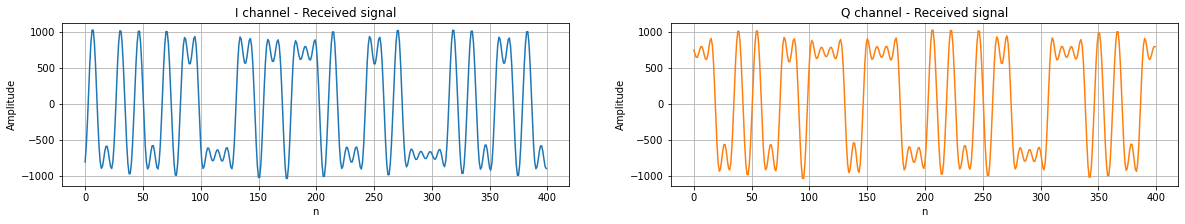

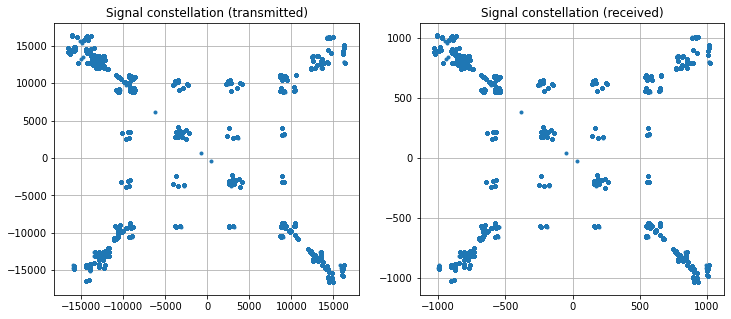

In [77]:
rtd = sdr.rx()

##########################################################################################
# Canal I: Parte real de la señal recibida
##########################################################################################
plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plt.plot(np.real(rtd[0:400]))
plt.title('I channel - Received signal')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid()

##########################################################################################
# Canal Q: Parte imaginaria de la señal recibida
##########################################################################################
plt.subplot(1,2,2)
plt.plot(np.imag(rtd[0:400]),'C1')
plt.title('Q channel - Received signal')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid()


##########################################################################################
# Diagramas de constelación
##########################################################################################
# Señal transmitida
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.real(st),np.imag(st),'.')
plt.title('Signal constellation (transmitted)')
plt.grid()

# Señal recibida
plt.subplot(1,2,2)
plt.plot(np.real(rtd),np.imag(rtd),'.')
plt.title('Signal constellation (received)')
plt.grid()

### Análisis de la señal recibida

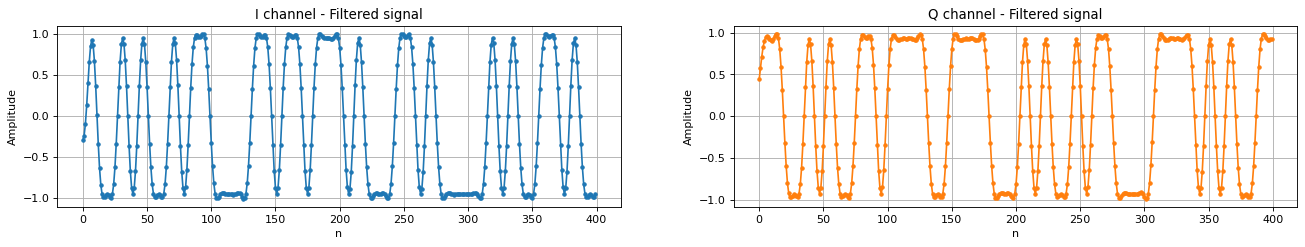

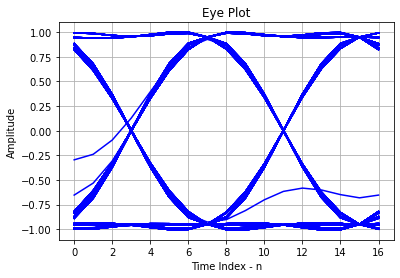

In [78]:
##########################################################################################
# Filtrado con RRC
##########################################################################################
# Filtro RRC:
beta = 0.99
t_rrc,h_rrc = np.conj(commpy.filters.rrcosfilter(num_taps,beta,Ts,fs))

# Canal I:
i_filteredd = np.convolve(np.real(rtd),h_rrc)
i_filteredd = i_filteredd[tau_g:-tau_g]/np.max(i_filteredd) # RElimino transitorios y normalizo
plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(i_filteredd[0:400],'.-')
plt.title('I channel - Filtered signal')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid()

# Canal Q:
q_filteredd = np.convolve(np.imag(rtd),h_rrc)
q_filteredd = q_filteredd[tau_g:-tau_g]/np.max(q_filteredd) # Elimino transitorios y normalizo
plt.subplot(1,2,2)
plt.plot(q_filteredd[0:400],'.-C1')
plt.title('Q channel - Filtered signal')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid()


##########################################################################################
# Diagrama ojo
##########################################################################################
i_datad = i_filteredd # ndarray of the real input data vector/array
L = sps*2           # display length in samples (usually two symbols)
S = 0               # start inde
dc.eye_plot(i_datad,L,S)
plt.show()

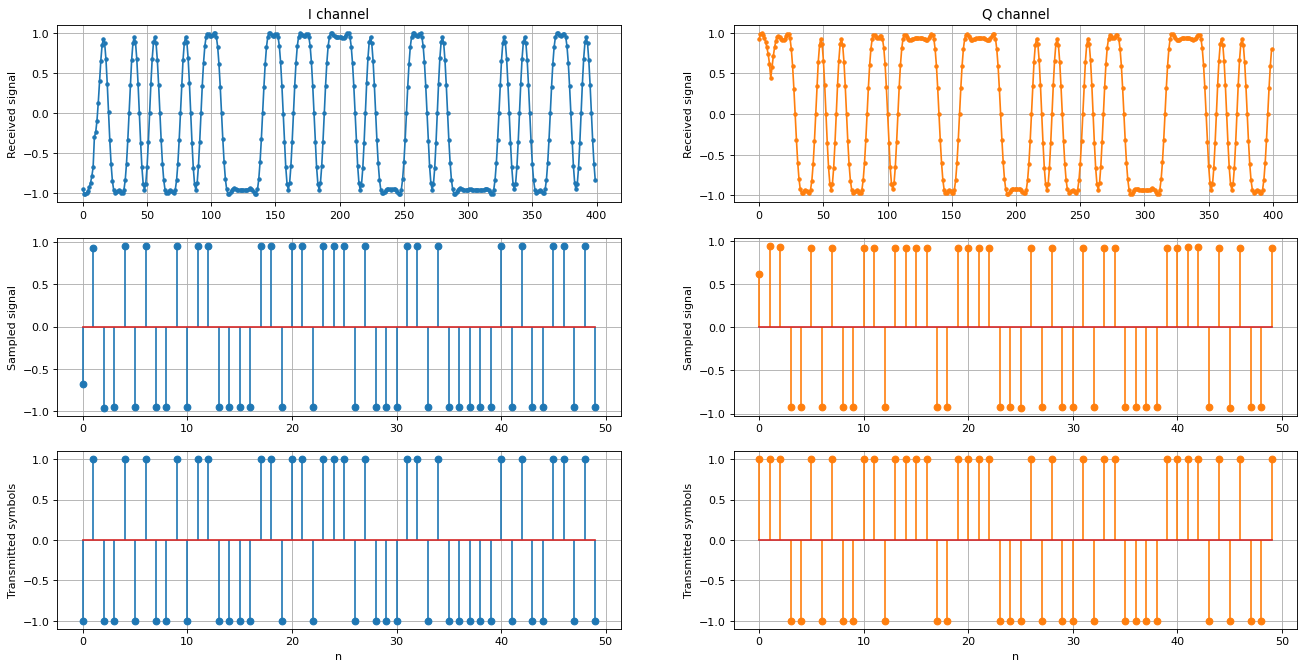

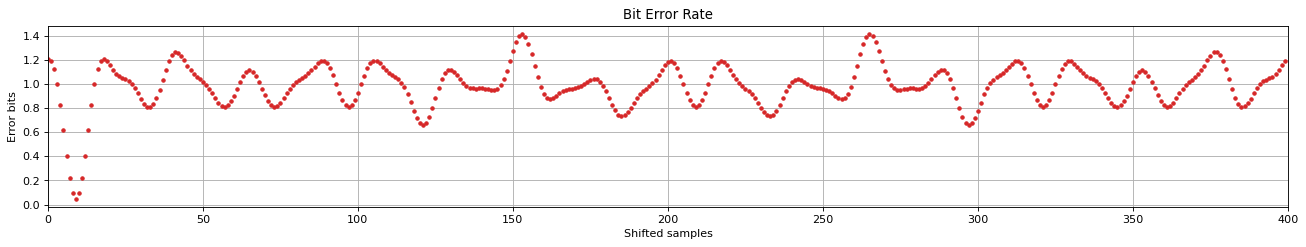

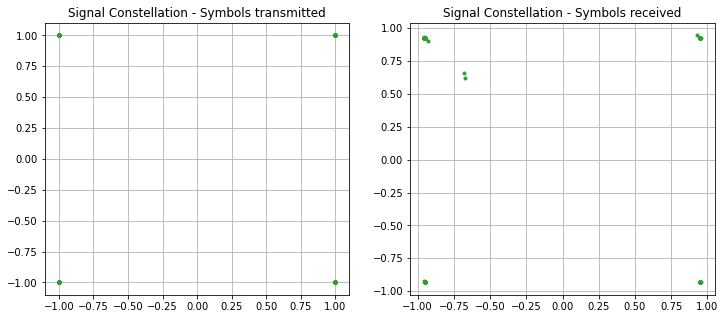

In [107]:
##########################################################################################
# Desplazamiento circular
##########################################################################################
shiftd = 9
i_shiftedd = np.roll(i_filteredd,shiftd)
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(3,2,1)
plt.plot(i_shiftedd[0:400],'.-')
plt.title('I channel')
plt.ylabel('Received signal')
plt.grid()

# Canal Q:
q_shiftedd = np.roll(q_filteredd,shiftd)
plt.subplot(3,2,2)
plt.plot(q_shiftedd[0:400],'C1.-')
plt.title('Q channel')
plt.ylabel('Received signal')
plt.grid()


##########################################################################################
# Sampling
##########################################################################################
# Canal I:
i_downd = i_shiftedd[sps::sps]
plt.subplot(3,2,3)
plt.stem(i_downd[0:50])
plt.ylabel('Sampled signal')
plt.grid()

# Canal Q:
q_downd = q_shiftedd[sps::sps]
plt.subplot(3,2,4)
plt.stem(q_downd[0:50],linefmt='C1-',markerfmt='C1o')
plt.ylabel('Sampled signal')
plt.grid()


##########################################################################################
# Símbolos transmitidos
##########################################################################################
# Canal I:
plt.subplot(3,2,5)
plt.stem(i_symbols[0:50])
plt.ylabel('Transmitted symbols')
plt.xlabel('n')
plt.grid()

# Canal Q:
plt.subplot(3,2,6)
plt.stem(q_symbols[0:50],linefmt='C1-',markerfmt='C1o')
plt.ylabel('Transmitted symbols')
plt.xlabel('n')
plt.grid()


##########################################################################################
# Bit Error Rate
##########################################################################################
plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Bit Error Rate')
plt.ylabel('Error bits')
plt.xlabel('Shifted samples')
plt.xlim([0,400])
plt.grid()
for i in range(400):
    i_berd = np.roll(i_filteredd,i)[sps::sps]
    ber_datad = np.sum(np.abs(i_berd - i_symbols[0:999]))/len(i_symbols[0:999])
    plt.plot(i,ber_datad,'C3.')
    #print('BER:',ber_data)


##########################################################################################
# Diagramas de constelación
##########################################################################################
# Símbolos transmitidos:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(i_symbols,q_symbols, 'C2.')
plt.title('Signal Constellation - Symbols transmitted')
plt.grid()

# Símbolos recibidos:
plt.subplot(1,2,2)
plt.plot(i_downd,q_downd, 'C2.')
plt.title('Signal Constellation - Symbols received')
plt.grid()
plt.show()

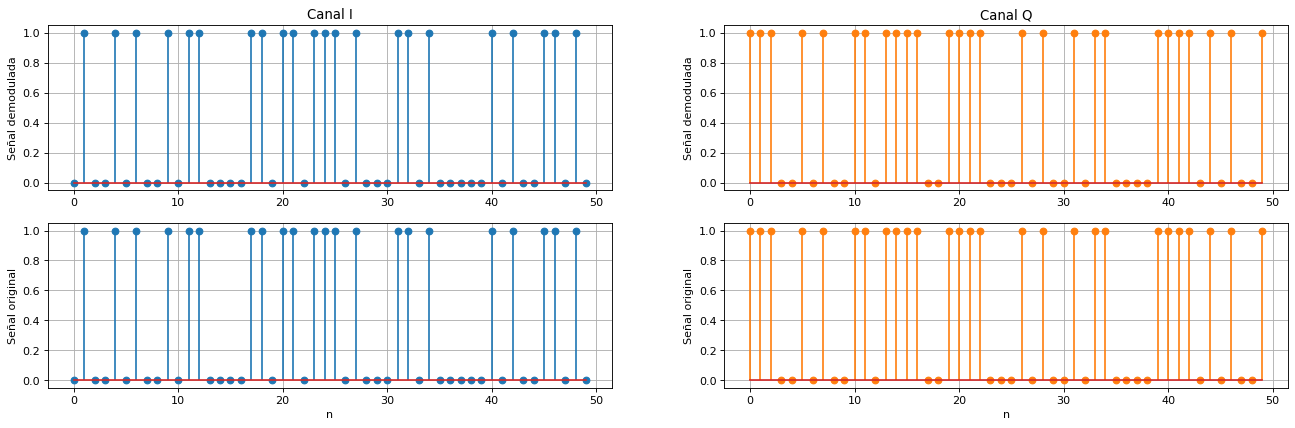

In [84]:
##########################################################################################
# Detección de umbral
##########################################################################################
# Canal I:
i_demodd=1*(i_downd>0)
plt.figure(figsize=(20, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,2,1)
plt.stem(i_demodd[0:50])
plt.title('Canal I')
plt.ylabel('Señal demodulada')
plt.grid()
plt.subplot(2,2,3)
plt.stem(i_bits[0:50])
plt.ylabel('Señal original')
plt.xlabel('n')
plt.grid()

# Canal Q:
q_demodd=1*(q_downd>0) # detector de umbral
plt.subplot(2,2,2)
plt.stem(q_demodd[0:50],linefmt='C1-',markerfmt='C1o')
plt.title('Canal Q')
plt.ylabel('Señal demodulada')
plt.grid()
plt.subplot(2,2,4)
plt.stem(q_bits[0:50],linefmt='C1-',markerfmt='C1o')
plt.ylabel('Señal original')
plt.xlabel('n')
plt.grid()

# Loopback analógico

In [58]:
# Conformación de la señal a transmitir:
st = (i_shaped + 1j*q_shaped)*2**14

sdr = adi.Pluto()

# Parámetros de transmisión:
sdr.tx_destroy_buffer()
sdr.tx_lo = 1000000000 # [Hz]
sdr.tx_cyclic_buffer = True
sdr.tx_hardwaregain_chan0 = -10

# Parámetros de recepción
sdr.rx_destroy_buffer()
sdr.rx_lo = 1000000000 # [Hz]
sdr.rx_rf_bandwidth = 10000
sdr.rx_cyclic_buffer = True
sdr.rx_buffer_size = len(st)
print('Tamaño del buffer:',sdr.rx_buffer_size,'muestras')
if sdr.rx_buffer_size<3660:
    print('Using less than 3660 samples per frame can yield poor performance')

sdr.gain_control_mode_chan0 = "slow_attack"
sdr.sample_rate = fs # [Hz]

fs_pluto = int(sdr.sample_rate)
print('Frecuencia de muestreo',fs_pluto,'Hz')

sdr.loopback = 0 # 0 (Disable), 1 (Digital), 2 (RF)
print('Loopback digital?:',sdr.loopback)

Tamaño del buffer: 8000 muestras
Frecuencia de muestreo 999999 Hz
Loopback digital?: 0


### Transmisón

In [59]:
sdr.tx(st)

### Recepción

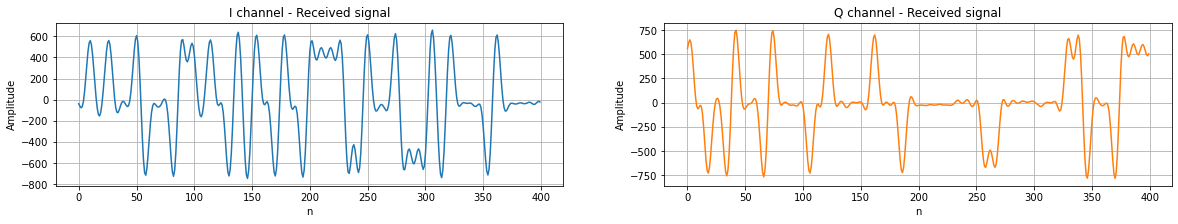

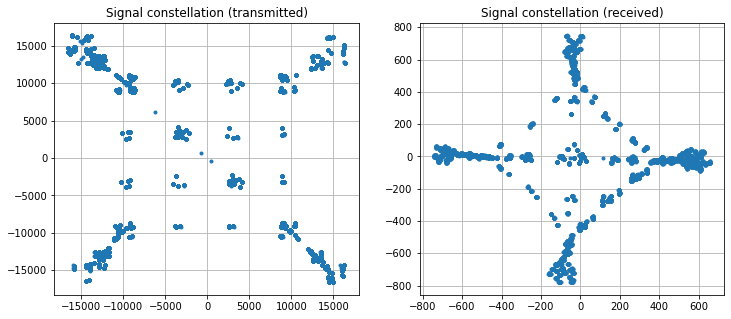

In [60]:
rt = sdr.rx()

##########################################################################################
# Canal I: Parte real de la señal recibida
##########################################################################################
plt.figure(figsize=(20,3))
plt.subplot(1,2,1)
plt.plot(np.real(rt[0:400]))
plt.title('I channel - Received signal')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid()

##########################################################################################
# Canal Q: Parte imaginaria de la señal recibida
##########################################################################################
plt.subplot(1,2,2)
plt.plot(np.imag(rt[0:400]),'C1')
plt.title('Q channel - Received signal')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid()


##########################################################################################
# Diagramas de constelación
##########################################################################################
# Señal transmitida
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.real(st),np.imag(st),'.')
plt.title('Signal constellation (transmitted)')
plt.grid()

# Señal recibida
plt.subplot(1,2,2)
plt.plot(np.real(rt),np.imag(rt),'.')
plt.title('Signal constellation (received)')
plt.grid()

### Análisis de la señal recibida

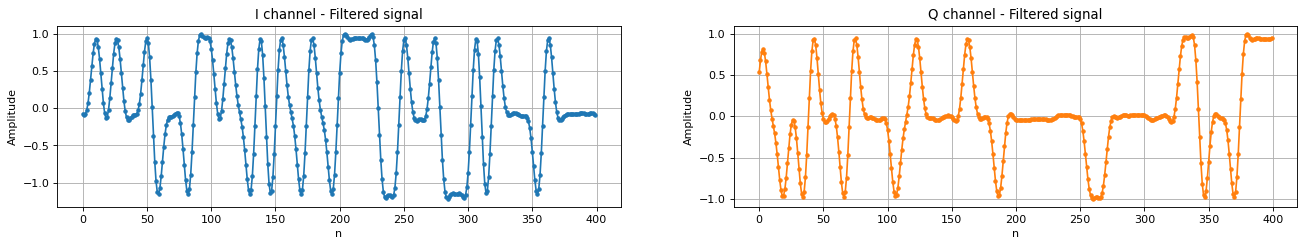

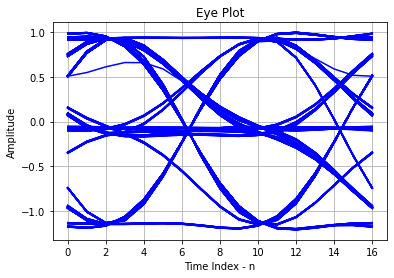

In [61]:
##########################################################################################
# Filtrado con RRC
##########################################################################################
# Filtro RRC:
beta = 0.99
t_rrc,h_rrc = np.conj(commpy.filters.rrcosfilter(num_taps,beta,Ts,fs))

# Canal I:
i_filtered = np.convolve(np.real(rt),h_rrc)
i_filtered = i_filtered[tau_g:-tau_g]/np.max(i_filtered) # RElimino transitorios y normalizo
plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(i_filtered[0:400],'.-')
plt.title('I channel - Filtered signal')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid()

# Canal Q:
q_filtered = np.convolve(np.imag(rt),h_rrc)
q_filtered = q_filtered[tau_g:-tau_g]/np.max(q_filtered) # Elimino transitorios y normalizo
plt.subplot(1,2,2)
plt.plot(q_filtered[0:400],'.-C1')
plt.title('Q channel - Filtered signal')
plt.ylabel('Amplitude')
plt.xlabel('n')
plt.grid()


##########################################################################################
# Diagrama ojo
##########################################################################################
i_data = i_filtered # ndarray of the real input data vector/array
L = sps*2           # display length in samples (usually two symbols)
S = 0               # start inde
dc.eye_plot(i_data,L,S)
plt.show()

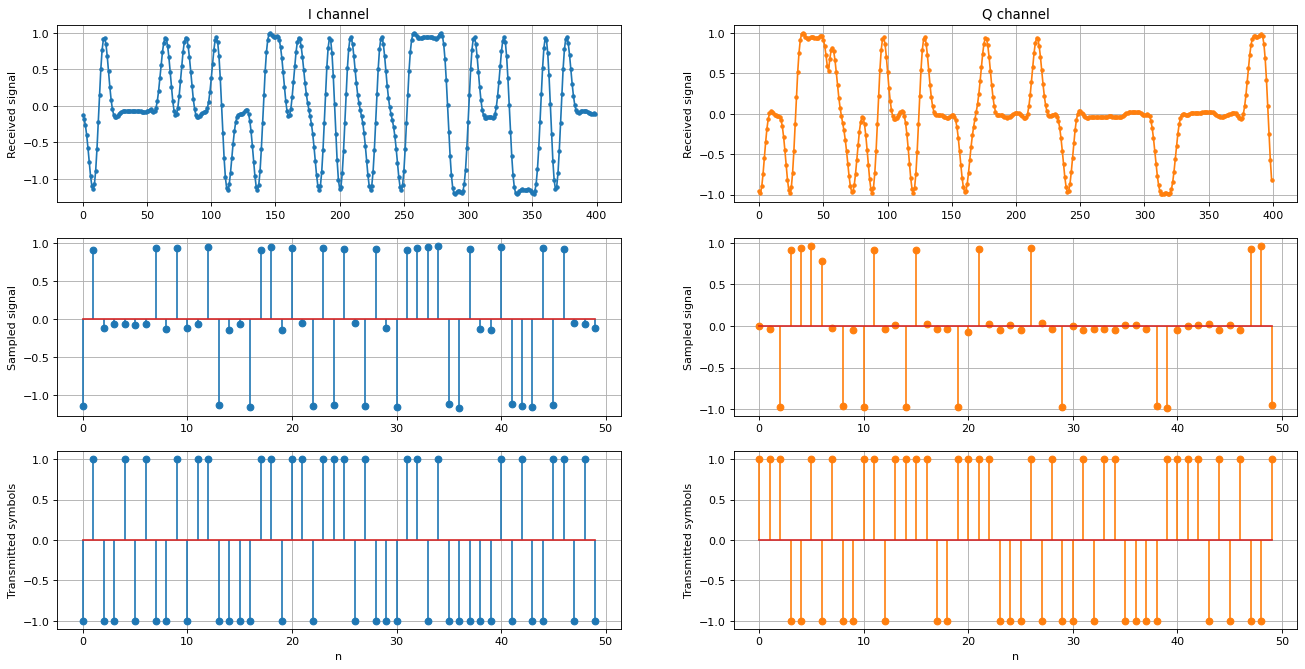

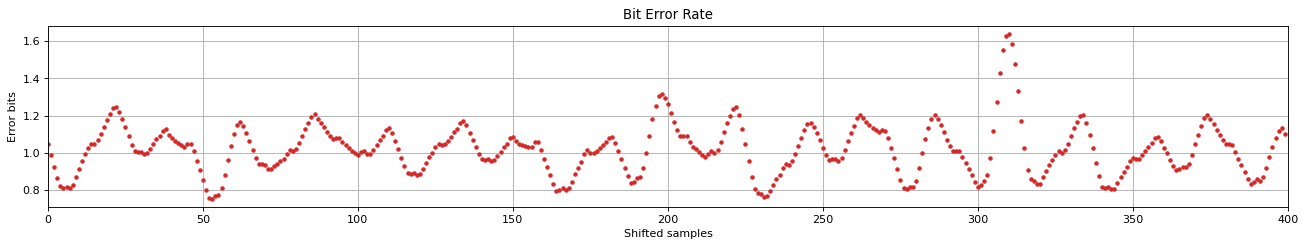

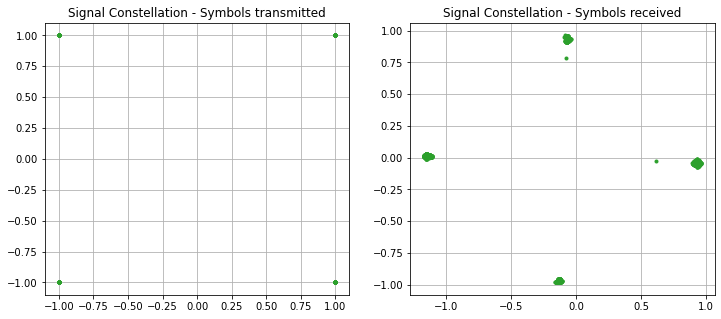

In [108]:
##########################################################################################
# Desplazamiento circular
##########################################################################################
shift = 54
i_shifted = np.roll(i_filtered,shift)
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(3,2,1)
plt.plot(i_shifted[0:400],'.-')
plt.title('I channel')
plt.ylabel('Received signal')
plt.grid()

# Canal Q:
q_shifted = np.roll(q_filtered,shift)
plt.subplot(3,2,2)
plt.plot(q_shifted[0:400],'C1.-')
plt.title('Q channel')
plt.ylabel('Received signal')
plt.grid()


##########################################################################################
# Sampling
##########################################################################################
# Canal I:
i_down = i_shifted[sps::sps]
plt.subplot(3,2,3)
plt.stem(i_down[0:50])
plt.ylabel('Sampled signal')
plt.grid()

# Canal Q:
q_down=q_shifted[sps::sps]
plt.subplot(3,2,4)
plt.stem(q_down[0:50],linefmt='C1-',markerfmt='C1o')
plt.ylabel('Sampled signal')
plt.grid()


##########################################################################################
# Símbolos transmitidos
##########################################################################################
# Canal I:
plt.subplot(3,2,5)
plt.stem(i_symbols[0:50])
plt.ylabel('Transmitted symbols')
plt.xlabel('n')
plt.grid()

# Canal Q:
plt.subplot(3,2,6)
plt.stem(q_symbols[0:50],linefmt='C1-',markerfmt='C1o')
plt.ylabel('Transmitted symbols')
plt.xlabel('n')
plt.grid()


##########################################################################################
# Bit Error Rate
##########################################################################################
plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Bit Error Rate')
plt.ylabel('Error bits')
plt.xlabel('Shifted samples')
plt.xlim([0,400])
plt.grid()
for i in range(400):
    i_ber = np.roll(i_filtered,i)[sps::sps]
    ber_data = np.sum(np.abs(i_ber - i_symbols[0:999]))/len(i_symbols[0:999])
    plt.plot(i,ber_data,'C3.')
    #print('BER:',ber_data)


##########################################################################################
# Diagramas de constelación
##########################################################################################
# Símbolos transmitidos:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(i_symbols,q_symbols, 'C2.')
plt.title('Signal Constellation - Symbols transmitted')
plt.grid()

# Símbolos recibidos:
plt.subplot(1,2,2)
plt.plot(i_down,q_down, 'C2.')
plt.title('Signal Constellation - Symbols received')
plt.grid()
plt.show()

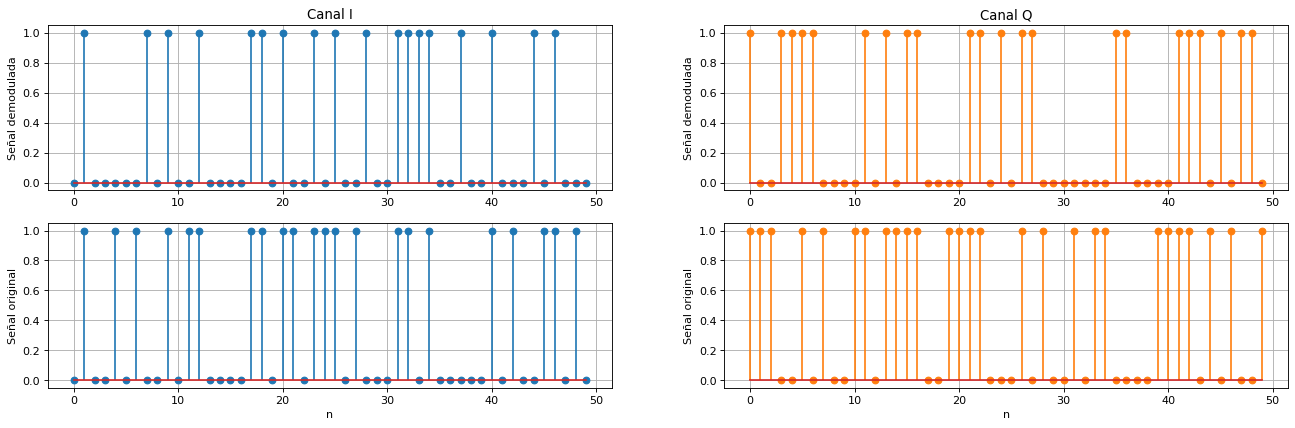

In [87]:
##########################################################################################
# Detección de umbral
##########################################################################################
# Canal I:
i_demod=1*(i_down>0)
plt.figure(figsize=(20, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,2,1)
plt.stem(i_demod[0:50])
plt.title('Canal I')
plt.ylabel('Señal demodulada')
plt.grid()
plt.subplot(2,2,3)
plt.stem(i_bits[0:50])
plt.ylabel('Señal original')
plt.xlabel('n')
plt.grid()

# Canal Q:
q_demod=1*(q_down>0) # detector de umbral
plt.subplot(2,2,2)
plt.stem(q_demod[0:50],linefmt='C1-',markerfmt='C1o')
plt.title('Canal Q')
plt.ylabel('Señal demodulada')
plt.grid()
plt.subplot(2,2,4)
plt.stem(q_bits[0:50],linefmt='C1-',markerfmt='C1o')
plt.ylabel('Señal original')
plt.xlabel('n')
plt.grid()

## Filtro Adaptado (Matched filter)
Un Filtro Adaptado es un sistema lineal invariante en el tiempo (SLIT) cuya función principal es detectar la presencia de una señal conocida dentro de una señal recibida, utilizando para ello una señal de referencia. La señal a la salida del filtro será la correlación de la señal referencia con la señal desconocida. El Filtro Adaptado es el sistema óptimo para maximizar la SNR en presencia de ruido.

### Respuesta en frecuencia del Filtro Adaptado
La respuesta en frecuencia del Filtro Adaptado es proporcional al complejo conjugado del espectro de la señal. Matemáticamente, la respuesta en frecuencia del Filtro Adaptado $H(f)$ puede expresarse como: 

\begin{equation}
H(f)=G_a\,S^∗(f)\,e^{−j2πft_1}
\end{equation}

donde:

$G_a$ es la ganancia máxima del filtro

$S^∗(f)$ es el complejo conjugado de la Transformada de Fourier de la señal de entrada $s(t)$

$t_1$ es el instante de tiempo en el cual la señal observada tiene su máximo

En general, el valor de $G_a$ es 1. Entonces, se puede escribir:

\begin{equation}
H(f)=S^*(f)\,e^{−j2πft_1}
\end{equation}

Donde $S^∗(f)$ es la magnitud y $e^{−j2πft_1}$ es la fase, que varía de manera uniforma con la frecuencia.

### Respuesta al impulso del Filtro Adaptado
En el dominio del tiempo, se puede obtener la salida $h(t)$ aplicando la Transformada de Fourier inversa de $H(f)$.

\begin{equation}
h(t)=\int_{-\infty}^{\infty}H(f)\,e^{−j2πft_1}df
\end{equation}

\begin{equation}
h(t)=\int_{-\infty}^{\infty}G_a\,S^*(f)\,e^{−j2πft_1}\,e^{j2πft}df
\end{equation}

\begin{equation}
h(t)=\int_{-\infty}^{\infty}G_a\,S^∗(f)\,e^{−j2πf(t_1−t)}df
\end{equation}

Conociendo la relación $S^∗(f)=S(−f)$:

\begin{equation}
h(t)=\int_{-\infty}^{\infty}G_a\,S(−f)\,e^{−j2πf(t_1−t)}df
\end{equation}

\begin{equation}
h(t)=\int_{-\infty}^{\infty}G_a\,S(f)\,ej^{2πf(t_1−t)}df
\end{equation}

\begin{equation}
h(t)=G_a\,s(t_1−t)
\end{equation}

Considerando $G_a = 1$:

\begin{equation}
h(t)=s(t_1−t)
\end{equation}

Se demuestra que la respuesta al impulso del Filtro Adaptado es la imagen espejo de la señal recibida en el instante $t_1$

### Filtro Adaptado en ADALM-PLUTO
Se implementó un Filtro Adaptado para una señal $chirp$, comúnmente utilizada en radares.

![MF1](TF_MF_1.png)

![MF2](TF_MF_2.png)

![MF3](TF_MF_3.png)

![MF4](TF_MF_4.png)

![MF5](TF_MF_5.png)

### Problema - Implementación en hardware
En la recepción de la señal con la placa ADALM-PLUTO, ¿cómo se manifiesta el efecto del ruido en el diagrama de constelación? 

Investigar y explicar a qué se debe la rotación en el diagrama de constelación. Tener en cuenta que este efecto aparece cuando se utiliza el frontend analógico (no hay loopback digital). Puede ser de utilidad el capítulo 7 del libro Software-Defined Radio for Engineers.

Opcional: ¿Qué otros fenómenos asociados al $hardware$ pueden manifestarse en el diagrama de constelación?